In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

In [2]:
with open("experiments/binomial_fg3m_rflvm.pickle", "rb") as file:
    data = pickle.load(file)
file.close()

In [3]:
import numpy as np
from scipy.linalg import svd 
from typing import Tuple

def varimax(Phi, gamma = 1.0, q = 20, tol = 1e-6):

    p,k = Phi.shape
    R = np.eye(k)
    d=0
    for i in range(q):
        d_old = d
        Lambda = np.dot(Phi, R)
        u,s,vh = svd(np.dot(Phi.T,np.asarray(Lambda)**3 - (gamma/p) * np.dot(Lambda, np.diag(np.diag(np.dot(Lambda.T,Lambda))))))
        R = np.dot(u,vh)
        d = np.sum(s)
        if d_old!=0 and d/d_old < 1 + tol: break
    return np.dot(Phi, R)


def rotate_factors(player_factor_tensor:np.ndarray, use_varimax:bool = True)->Tuple[np.ndarray, np.ndarray]:
    """

    Args:
        player_factor_tensor (np.ndarray): sample x num factors x num players 
        varimax (bool): whether to apply varimax rotation or not

    Returns:
        np.ndarray: sample x num factors x num players  rotated tensor
    """

    n_samples, n_factors, _ = player_factor_tensor.shape
    output_tensor = np.zeros_like(player_factor_tensor)
    rotations = [np.eye(n_factors)]
    output_tensor[0,:,:] = player_factor_tensor[0,:,:] if not use_varimax else varimax(player_factor_tensor[0,:,:])
    for i in range(1,n_samples):
        U, _, V =  svd(output_tensor[0,:,:].dot(player_factor_tensor[i,:,:].T), full_matrices=False)
        rotation = U.dot(V)
        rotations.append(rotation)
        output_tensor[i,:,:] = rotation.dot(player_factor_tensor[i,:,:])
    print(len(rotations))
    return output_tensor, np.stack(rotations,axis = 0)




In [4]:
rotated_data = rotate_factors(np.swapaxes(data["X"], axis1 = 1, axis2=2))

1000


In [5]:
rotated_means = rotated_data[0].mean(axis=0).T

NameError: name 'plt' is not defined

In [6]:
import pandas as pd
df = pd.read_csv("datasets/player_data.csv")

In [7]:
df = df.sort_values(by=["id","year"])
df_max_vals = df[["fg3m", "fg3a", "id" ]].groupby("id").sum().reset_index()

In [8]:
df_max_vals

,id,fg3m,fg3a
0,2,73,188
1,3,27,108
2,7,0,1
3,9,8,20
4,12,0,0
...,...,...,...
2327,1630267,76,216
2328,1630268,2,7
2329,1630271,16,59
2330,1630273,0,0


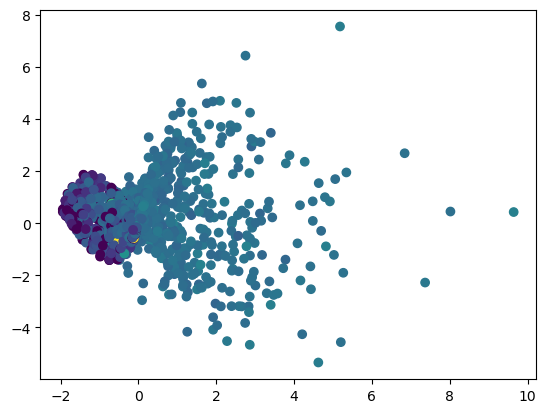

In [10]:
plt.scatter(rotated_means[:,0], rotated_means[:,1], c= df_max_vals["fg3m"]/df_max_vals["fg3a"])
